In [11]:
from scipy import special
from scipy import optimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import random as rand

In [2]:
def switch_freq(subj):
    i = subj[2]
    switcher = {
        'L':range(10,20+1,1),
        'H':range(25,35+1,1)
    }
    return switcher.get(i,"Error : Invalid subj ID")

In [3]:
MATLAB_drive = '/Users/clmn/MATLAB-Drive'
behav_dir = MATLAB_drive + '/TM experiment/TM_behavior/behav_data/'

In [4]:
subj = 'TML01_pilot'
freq_range = switch_freq(subj)
freq_c = freq_range[5]

In [5]:
def greek(letter):
    switcher = {
        'alpha':'\u03B1',   'ALPHA':'\u0391',
        'beta':'\u03B2',    'BETA':'\u0392',
        'gamma':'\u03B3',   'GAMMA':'\u0393',
        'delta':'\u03B4',   'DELTA':'\u0394',
        'epilson':'\u03B5', 'EPSILON':'\u0395',
        'zeta':'\u03B6',    'ZETA':'\u0396',
        'eta':'\u03B7',     'ETA':'\u0397',
        'theta':'\u03B8',   'THETA':'\u0398',
        'iota':'\u03B9',    'IOTA':'\u0399',
        'kappa':'\u03BA',   'KAPPA':'\u039A',
        'lamda':'\u03BB',   'LAMDA':'\u039B',
        'mu':'\u03BC',      'MU':'\u039C',
        'nu':'\u03BD',      'NU':'\u039D',
        'xi':'\u03BE',      'XI':'\u039E',
        'omicron':'\u03BF', 'OMICRON':'\u039F',
        'pi':'\u03C0',      'PI':'\u03A0',
        'rho':'\u03C1',     'RHO':'\u03A1',
        'sigma':'\u03C3',   'SIGMA':'\u03A3',
        'tau':'\u03C4',     'TAU':'\u03A4',
        'phi':'\u03C6',     'PHI':'\u03A6',
        'chi':'\u03C7',     'CHI':'\u03A7',
        'psi':'\u03C8',     'PSI':'\u03A8',
        'omega':'\u03C9',   'OMEGA':'\u03A9'
    }
    return switcher.get(letter, "Error : Invalid letter")

In [6]:
def calc_freq_class(freq_range, freq):
    #freq_range = range(10,20+1,1)
    freqs = [x for x in freq_range]
    f_mid = int((freqs[0]+freqs[-1])*0.5)
    return int(freq - f_mid)

## Psychometric Curve Fitting

In [46]:
def get_dataframe_DIS(subj):
    subj_behav_datum = behav_dir + subj + '/%s_Dis.dat' %subj
    df = pd.read_csv(subj_behav_datum, sep='\t', header=None)
    df.columns=['trial', 'Freq.1', 'ISI1', 'Freq.2', 'ISI2', 'decision', 'correctness', 'RT', 'ISI3']
#     df['Freq.1.class'] = [np.int64(np.sign(f-freq_c)) for f in df['Freq.1']]
#     df['Freq.2.class'] = [np.int64(np.sign(f-freq_c)) for f in df['Freq.2']]
#     df['Freq.other.index'] = [1 if a != 0 else 2 for a in df['Freq.1.class']]
#     df['Freq.other.class'] = [a+b for a, b in zip(df['Freq.1.class'], df['Freq.2.class'])]
    df['answer.index'] = [1 if a>b else 2 for a, b in zip(df['Freq.1'], df['Freq.2'])]
    df['decision.index'] = [1 if x == 'before' else (2 if x=='after' else 'NaN') for i, x in enumerate(df['decision'])]
#     df['Freq.other_decision.class'] = ['NaN' if b=='NaN' else (1 if a==b else -1) for a,b in zip(df['Freq.other.index'],df['decision.index'])]

    df['Freq.1.diff'] = [calc_freq_class(freq_range,f) for f in df['Freq.1']]
    df['Freq.2.diff'] = [calc_freq_class(freq_range,f) for f in df['Freq.2']]
    df['Freq.other.diff'] = [a+b for a, b in zip(df['Freq.1.diff'], df['Freq.2.diff'])]
    df['F1<F2.class'] = [np.sign(b-a) for a, b in zip(df['Freq.1'], df['Freq.2'])]
    df['F1<F2.diff'] = [b-a for a, b in zip(df['Freq.1'], df['Freq.2'])]

    return df

def scatter_x_y(subj):
    df = get_dataframe_DIS(subj)
    da = df[['answer.index','decision.index','Freq.other.diff']]
    
#     c = range(-5,6) # contrast
    c = np.arange(-5,6) # contrast

    db = pd.DataFrame(index = ['prob'], columns = c)
    for rank in c:
        temp = (da['decision.index'] != 'NaN')&(da['Freq.other.diff'] == rank)&(da['answer.index'] == da['decision.index'])
        n = len(da[temp])
        db[rank] = n * np.sign(rank)
    maxfreq = max(freq_range)
    db = db/maxfreq * 0.5 + 0.5
    prob = np.array(db).reshape(len(c))
    return c+freq_c, prob

def func_ideal_observer(x, a,b,r,k):
    n = freq_c
    return 0.5*(1+special.erf( k/(a*k**r)**(0.5) * (x**b-n**b)/np.sqrt(x**(b*r)+n**(b*r)) ))

def func_error(x, mu,s):
    ## Error function
    ## 'mu' means mean
    ## 's' means deviation
    return 0.5*(1+special.erf((x-mu)/(np.sqrt(2)*s)))

def func_logistic(x, a,b):
    ## Logistic function
    ## freeparameter : a, b
    ## 'a' can be interpreted as the 75% threshold
    ## 'b' as a scaling factor that is inversely related to the slope of the psychometric function.
    return special.expit((x-a)/b)

def func_Weibull(x, a,b):
    ## Weibull cumulative distribution function
    ## 'a' summarises the effect of the stimulus
    ## 'b' reflets to the effect of noise
    g = 0.5 # chance level
    y = []
    for k in x:
        temp = k - freq_c
        if temp > 0:
            y.append(1 - (1-g)*np.exp(-a * (temp**b)))
        elif temp == 0:
            y.append(g)
        else:
            y.append(0)
    return np.asarray(y)

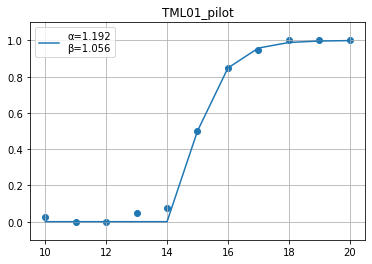

In [74]:
x, prob = scatter_x_y(subj)

# params, params_covariance = optimize.curve_fit(test_func, t, prob, p0=[0.1,0.1,0.1,0.1], maxfev=1000)

## error function
# test_func = func_error
# params, params_covariance = optimize.curve_fit(test_func, x, prob, p0=[15,1], maxfev=500)
# JND=special.erfinv(0.5)*(np.sqrt(2)*params[1]); # JND for 75%
# plt.plot(x, test_func(x, params[0],params[1]), label='%s=%.3fHz\nJND=%.3fHz'%(greek('mu'),params[0],JND))

## logistic function
# test_func = func_logistic
# params, params_covariance = optimize.curve_fit(test_func, x, prob, p0=[1,1], maxfev=500)
# plt.plot(x, test_func(x, params[0],params[1]), label='%s=%.3f\n%s=%.3f'%(greek('alpha'),params[0],greek('beta'),params[1]))

## Weibull function
test_func = func_Weibull
params, params_covariance = optimize.curve_fit(test_func, x, prob, p0=[10*rand(),10*rand()], maxfev=300, bounds=([0.0001,0.0001] , [100, 100]))
# bounds : constraint, 0.0001 <= a <= 100, 0.0001 <= b <= 100
plt.plot(x, test_func(x, params[0],params[1]), label='%s=%.3f\n%s=%.3f'%(greek('alpha'),params[0],greek('beta'),params[1]))

plt.scatter(x=x,y=prob)
plt.legend(loc='best')
plt.ylim([-.1,1.1])

plt.title(subj)
plt.grid()
#plt.savefig(fname=subj+'_curve.png',dpi=300)

## Hidden Target Search Task